# Electric Circuit Usage Analysis
This workbook looks at usage patterns for a selection of charging locations near Colin and Ryan

First lets get the data loaded and look at the table so we can understand what information is available to us...

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('charger_status2.csv')
df.head()

,timestamp,name,status,availableCount,count
0,2024-11-29T21:13:20.557540,5034 | BSR | PMR | 5223 St-Laurent,inUse,0,2
1,2024-11-29T21:13:20.557540,5006 | BSR | PMR | 5004 St-Laurent : Parc Lahaie,inUse,0,2
2,2024-11-29T21:13:20.557540,Allied - 5455 de Gaspé,available,2,2
3,2024-11-29T21:13:20.557540,Allied - 5445 de Gaspé,available,1,2
4,2024-11-29T21:13:20.557540,5026 | BSR | PMR | 5561 St-Dominique,available,1,2


#### Lets look at the general fraction of each hour that any charger is available 

This gives us the probability of any of the chargers being free within that hour to give us a general sense of business over the time period we've logged. Its not practically helpful as its combining all chargers into one availability fraction.

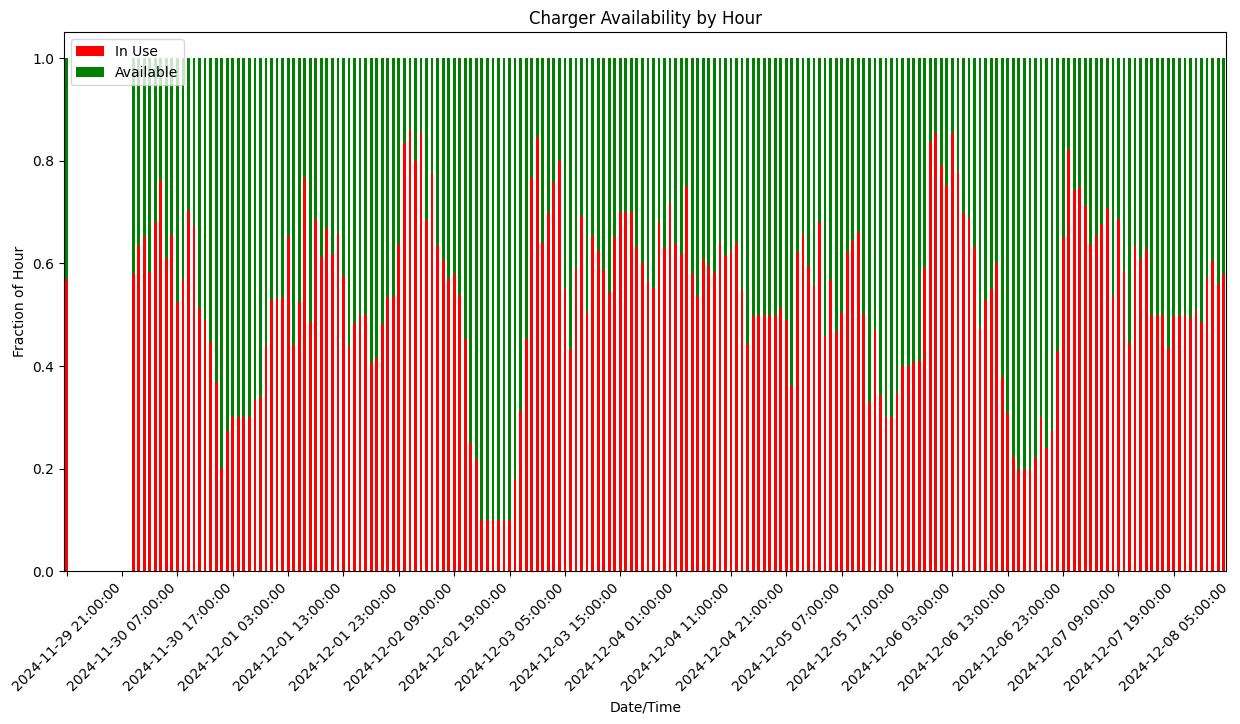

In [81]:
# Convert the timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')

# Drop rows with NaT values in the timestamp column
df = df.dropna(subset=['timestamp'])

# Create a new column to indicate whether the available count is 0 or greater than 0
df['in_use'] = df['availableCount'] == 0

# Resample the data by hour and calculate the fraction of time for each condition
hourly_data = df.resample('h', on='timestamp').apply(lambda x: x['in_use'].mean())

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'in_use': hourly_data,
    'available': 1 - hourly_data
})

# Plot the stacked bar chart
ax = plot_data.plot(kind='bar', stacked=True, figsize=(15, 7), color=['red', 'green'])
plt.xlabel('Date/Time')
plt.ylabel('Fraction of Hour')
plt.title('Charger Availability by Hour')
plt.legend(['In Use', 'Available'])

# Show every tenth tick label
ticks = ax.get_xticks()
ax.set_xticks(ticks[::10])
ax.set_xticklabels(plot_data.index[::10], rotation=45)

plt.show()

## This is the list of chargers we have:

In [67]:
# Print a distinct list of all the chargers
unique_chargers = df['name'].unique()
print("Distinct list of all chargers:")
print(unique_chargers)

Distinct list of all chargers:
['5034 | BSR | PMR | 5223 St-Laurent'
 '5006 | BSR | PMR | 5004 St-Laurent : Parc Lahaie'
 'Allied - 5455 de Gaspé' 'Allied - 5445 de Gaspé'
 '5026 | BSR | PMR | 5561 St-Dominique' '5013 | BSR | PMR | 5055 Rivard'
 '5035 | BSR | PMR | 5110 Chambord' '5014 | BSR | PMR | 5333 Papineau'
 '5015 | BSR | PMR | 4801 Papineau' '5022 | BSR | PMR | 4490 Fabre']


#### We'll now apply a mapping of the user Ryan or Colin to those chargers

In [68]:
# Create a mapping dictionary
charger_mapping = {
    "5006 | BSR | PMR | 5004 St-Laurent : Parc Lahaie": "Ryan",
    "5013 | BSR | PMR | 5055 Rivard": "Ryan",
    "5014 | BSR | PMR | 5333 Papineau": "Ryan",
    "5015 | BSR | PMR | 4801 Papineau": "Ryan",
    "5022 | BSR | PMR | 4490 Fabre": "Ryan",
    "5026 | BSR | PMR | 5561 St-Dominique": "Colin",
    "5034 | BSR | PMR | 5223 St-Laurent": "Colin",
    "5035 | BSR | PMR | 5110 Chambord": "Colin",
    "Allied - 5445 de Gaspé": "Colin",
    "Allied - 5455 de Gaspé": "Colin"
}

# Add a new column to the DataFrame
df['assigned_to'] = df['name'].map(charger_mapping)

# Verify the new column
print(df[['name', 'assigned_to']].drop_duplicates())

                                                name assigned_to
0                 5034 | BSR | PMR | 5223 St-Laurent       Colin
1   5006 | BSR | PMR | 5004 St-Laurent : Parc Lahaie        Ryan
2                             Allied - 5455 de Gaspé       Colin
3                             Allied - 5445 de Gaspé       Colin
4               5026 | BSR | PMR | 5561 St-Dominique       Colin
5                     5013 | BSR | PMR | 5055 Rivard        Ryan
24                  5035 | BSR | PMR | 5110 Chambord       Colin
25                  5014 | BSR | PMR | 5333 Papineau        Ryan
26                  5015 | BSR | PMR | 4801 Papineau        Ryan
27                     5022 | BSR | PMR | 4490 Fabre        Ryan


#### The following plot shows a 24 hour x axis, which is data from any day to show an hourly pattern. This chart is repeated for Ryan and Colin's chargers to see when they are typically busy.

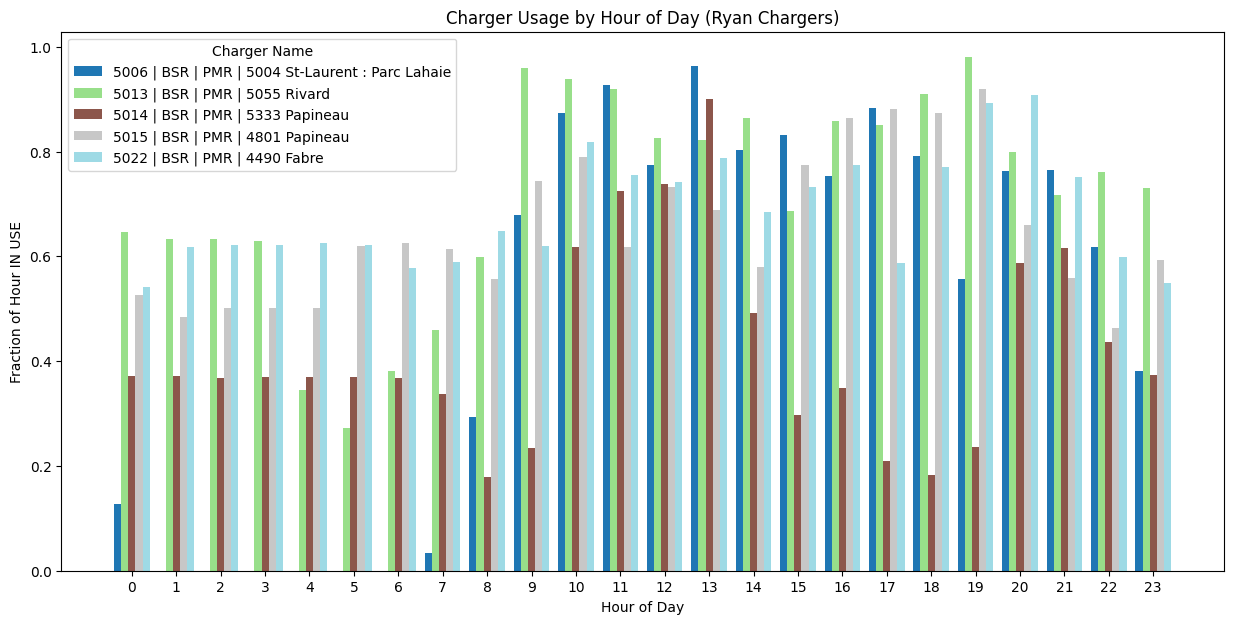

In [82]:
# Create a new column to indicate whether the available count is 0 or greater than 0
df['in_use'] = df['availableCount'] == 0

# Extract the hour of the day from the timestamp
df['hour_of_day'] = df['timestamp'].dt.hour

# Filter the DataFrame to include only the "Ryan" chargers
df_ryan = df[df['assigned_to'] == 'Ryan']

# Filter the DataFrame to include only the "Colin" chargers
df_colin = df[df['assigned_to'] == 'Colin']

# Group the data by charger name and hour of the day, and calculate the fraction of time for each condition
hourly_data_by_charger_ryan = df_ryan.groupby(['name', 'hour_of_day'])['in_use'].mean().unstack(level=0)

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(15, 7))

# Define the number of chargers and the width of each bar
num_chargers = len(hourly_data_by_charger_ryan.columns)
bar_width = 0.8 / num_chargers

# Define the colors for each charger
colors = plt.get_cmap('tab20', num_chargers)

# Plot each charger separately
for i, charger in enumerate(hourly_data_by_charger_ryan.columns):
    x = np.arange(len(hourly_data_by_charger_ryan.index)) + i * bar_width
    ax.bar(x, hourly_data_by_charger_ryan[charger], width=bar_width, color=colors(i), label=charger)

# Set the x-axis labels
ax.set_xticks(np.arange(len(hourly_data_by_charger_ryan.index)) + bar_width * (num_chargers - 1) / 2)
ax.set_xticklabels(hourly_data_by_charger_ryan.index)

plt.xlabel('Hour of Day')
plt.ylabel('Fraction of Hour IN USE')
plt.title('Charger Usage by Hour of Day (Ryan Chargers)')
plt.legend(title='Charger Name')
plt.xticks(rotation=0)
plt.show()

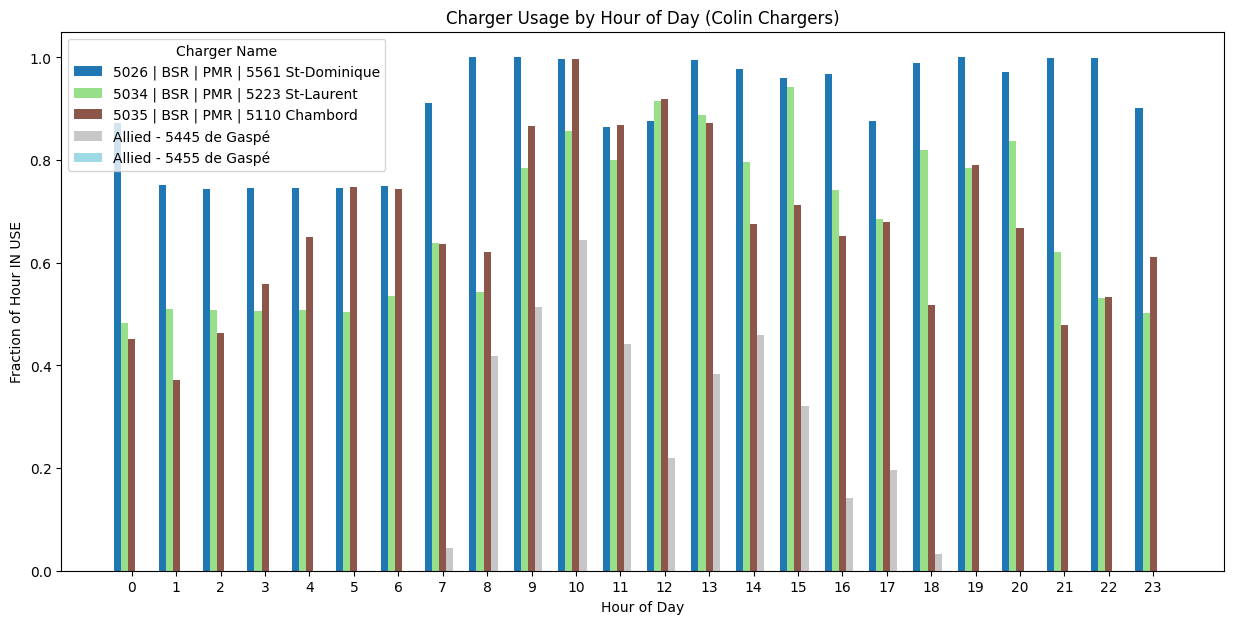

In [83]:
# Group the data by charger name and hour of the day, and calculate the fraction of time for each condition
hourly_data_by_charger_colin = df_colin.groupby(['name', 'hour_of_day'])['in_use'].mean().unstack(level=0)

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(15, 7))

# Define the number of chargers and the width of each bar
num_chargers = len(hourly_data_by_charger_colin.columns)
bar_width = 0.8 / num_chargers

# Define the colors for each charger
colors = plt.get_cmap('tab20', num_chargers)

# Plot each charger separately
for i, charger in enumerate(hourly_data_by_charger_colin.columns):
    x = np.arange(len(hourly_data_by_charger_colin.index)) + i * bar_width
    ax.bar(x, hourly_data_by_charger_colin[charger], width=bar_width, color=colors(i), label=charger)

# Set the x-axis labels
ax.set_xticks(np.arange(len(hourly_data_by_charger_colin.index)) + bar_width * (num_chargers - 1) / 2)
ax.set_xticklabels(hourly_data_by_charger_colin.index)

plt.xlabel('Hour of Day')
plt.ylabel('Fraction of Hour IN USE')
plt.title('Charger Usage by Hour of Day (Colin Chargers)')
plt.legend(title='Charger Name')
plt.xticks(rotation=0)
plt.show()

In [71]:
# Identify charging sessions
df['session_start'] = (df['availableCount'].shift(1) > df['availableCount']) & (df['availableCount'] < 2)
df['session_end'] = (df['availableCount'].shift(1) < df['availableCount']) & (df['availableCount'] > 0)

# Filter out rows where no session starts or ends
sessions = df[(df['session_start']) | (df['session_end'])]

# Debug: Check the session start and end times
# print("\nSessions with Start and End Flags:")
# print(sessions[['timestamp', 'name', 'availableCount', 'session_start', 'session_end']].head(20))

In [134]:
# Ensure the data is sorted by timestamp
sessions = sessions.sort_values(by=['name', 'timestamp'])

# Initialize list to store session data
session_data = []

# Iterate through the sessions to calculate durations
for name, group in sessions.groupby('name'):
    start_time = None
    for _, row in group.iterrows():
        if row['session_start']: #if session_start flag is True
            start_time = row['timestamp']
        elif row['session_end'] and start_time is not None:
            duration = row['timestamp'] - start_time
             # Only append the session if its duration is more than 5 minutes as that's our polling rate
            if duration.total_seconds() > 300:
                session_data.append({'name': name, 'duration': duration, 'session_start': start_time})
            start_time = None

# Create a DataFrame from the session data
session_durations = pd.DataFrame(session_data)

# Debug: Check the calculated durations
print("Session Durations:")
print(session_durations.head(10))

Session Durations:
                                               name               duration  \
0  5006 | BSR | PMR | 5004 St-Laurent : Parc Lahaie 0 days 00:07:02.899749   
1  5006 | BSR | PMR | 5004 St-Laurent : Parc Lahaie 0 days 00:12:03.828495   
2  5006 | BSR | PMR | 5004 St-Laurent : Parc Lahaie 0 days 02:09:35.849122   
3  5006 | BSR | PMR | 5004 St-Laurent : Parc Lahaie 0 days 00:17:04.040908   
4  5006 | BSR | PMR | 5004 St-Laurent : Parc Lahaie 0 days 00:41:06.901457   
5  5006 | BSR | PMR | 5004 St-Laurent : Parc Lahaie 0 days 00:12:13.706148   
6  5006 | BSR | PMR | 5004 St-Laurent : Parc Lahaie 0 days 00:35:19.590547   
7  5006 | BSR | PMR | 5004 St-Laurent : Parc Lahaie 0 days 00:21:09.593419   
8  5006 | BSR | PMR | 5004 St-Laurent : Parc Lahaie 0 days 00:35:47.169039   
9  5006 | BSR | PMR | 5004 St-Laurent : Parc Lahaie 0 days 00:24:06.101586   

               session_start  
0 2024-11-30 13:54:19.687710  
1 2024-11-30 18:32:18.842789  
2 2024-11-30 22:33:15.866757 

#### Maximum, Minimum and Mean charging durations per Charge Station

In [135]:
# Calculate the minimum, maximum, and mean charging duration for each station
min_durations = session_durations.groupby('name')['duration'].min().reset_index()
max_durations = session_durations.groupby('name')['duration'].max().reset_index()
mean_durations = session_durations.groupby('name')['duration'].mean().reset_index()

# Convert durations to minutes
min_durations['min_duration'] = min_durations['duration'].dt.total_seconds() / 60
max_durations['max_duration'] = max_durations['duration'].dt.total_seconds() / 60
mean_durations['mean_duration'] = mean_durations['duration'].dt.total_seconds() / 60

# Merge min, max, and mean durations into a single DataFrame
durations = pd.merge(min_durations[['name', 'min_duration']], max_durations[['name', 'max_duration']], on='name')
durations = pd.merge(durations, mean_durations[['name', 'mean_duration']], on='name')

# Debug: Check the min, max, and mean durations
print("\nMin, Max, and Mean Charging Durations per Station:")
print(durations)


Min, Max, and Mean Charging Durations per Station:
                                               name  min_duration  \
0  5006 | BSR | PMR | 5004 St-Laurent : Parc Lahaie      6.405853   
1                    5013 | BSR | PMR | 5055 Rivard      6.038241   
2                  5014 | BSR | PMR | 5333 Papineau      7.071952   
3                  5015 | BSR | PMR | 4801 Papineau     14.087451   
4                     5022 | BSR | PMR | 4490 Fabre      5.109115   
5              5026 | BSR | PMR | 5561 St-Dominique      8.387122   
6                5034 | BSR | PMR | 5223 St-Laurent      6.033925   
7                  5035 | BSR | PMR | 5110 Chambord      5.276522   
8                            Allied - 5445 de Gaspé     12.071470   
9                            Allied - 5455 de Gaspé     17.222618   

   max_duration  mean_duration  
0    129.597485      40.805443  
1    417.115480     113.650769  
2    626.161267      70.435693  
3    564.258625      94.830345  
4    426.149750     106

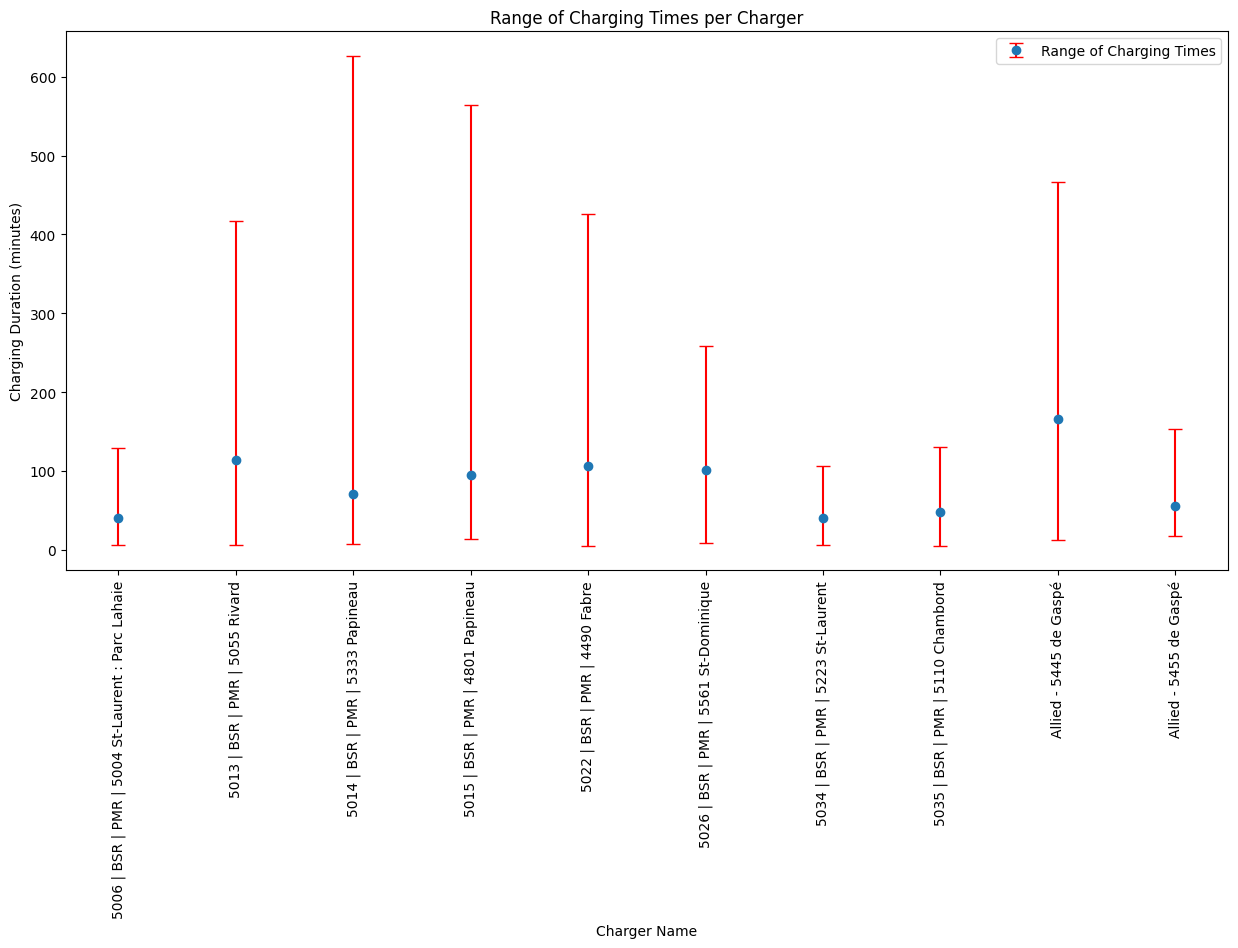

In [136]:
# Plot the range of charging times for each charger
fig, ax = plt.subplots(figsize=(15, 7))

# Plot min and max durations as error bars with the mean as the central point
ax.errorbar(durations['name'], durations['mean_duration'], yerr=[durations['mean_duration'] - durations['min_duration'], durations['max_duration'] - durations['mean_duration']], fmt='o', ecolor='red', capsize=5, label='Range of Charging Times')

plt.xlabel('Charger Name')
plt.ylabel('Charging Duration (minutes)')
plt.title('Range of Charging Times per Charger')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [137]:
# Extract the date from the session start timestamp
session_durations['session_date'] = session_durations['session_start'].dt.date

# Group by charger name and session date, then count the number of sessions per day
sessions_per_day = session_durations.groupby(['name', 'session_date']).size().reset_index(name='session_count')

# Calculate the average number of sessions per day for each charger
average_sessions_per_day = sessions_per_day.groupby('name')['session_count'].mean().reset_index()
average_sessions_per_day.columns = ['name', 'average_sessions_per_day']

# Debug: Check the average sessions per day
print("Average Sessions Per Day:")
print(average_sessions_per_day.head(10))

Average Sessions Per Day:
                                               name  average_sessions_per_day
0  5006 | BSR | PMR | 5004 St-Laurent : Parc Lahaie                  2.875000
1                    5013 | BSR | PMR | 5055 Rivard                  1.428571
2                  5014 | BSR | PMR | 5333 Papineau                  2.666667
3                  5015 | BSR | PMR | 4801 Papineau                  1.875000
4                     5022 | BSR | PMR | 4490 Fabre                  2.625000
5              5026 | BSR | PMR | 5561 St-Dominique                  1.500000
6                5034 | BSR | PMR | 5223 St-Laurent                  2.222222
7                  5035 | BSR | PMR | 5110 Chambord                  2.625000
8                            Allied - 5445 de Gaspé                  1.200000
9                            Allied - 5455 de Gaspé                  1.250000


In [138]:
# Convert durations to minutes for easier bucketing
session_durations['duration_minutes'] = session_durations['duration'].dt.total_seconds() / 60

# # Debug: Check the session durations
# print("Session Durations in Minutes:")
# print(session_durations.head(10))

#### Average number of charging sessions per day at each Charger
maybe we should add error bars on this for min and max count of sessions per day?

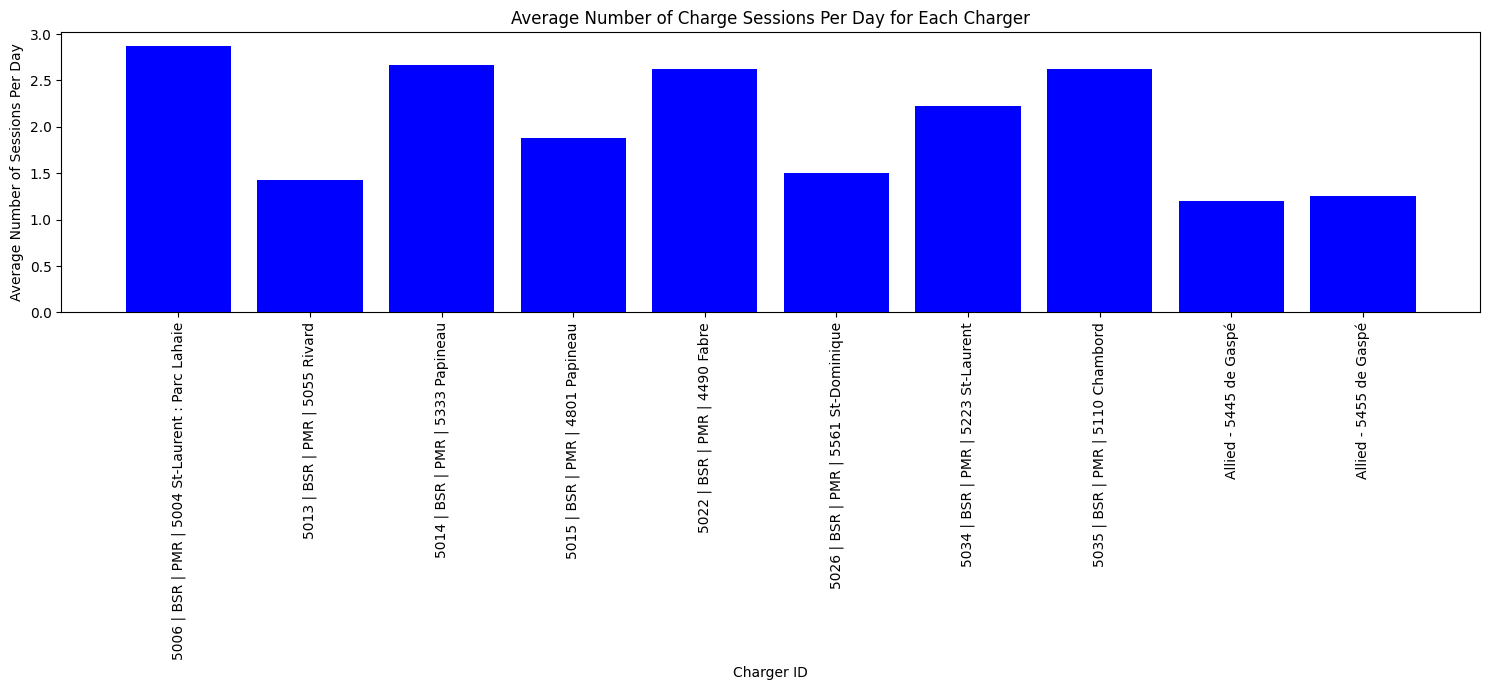

In [139]:
# Plot the average number of charge sessions per day for each charger
fig, ax = plt.subplots(figsize=(15, 7))

ax.bar(average_sessions_per_day['name'], average_sessions_per_day['average_sessions_per_day'], color='blue')

# Add labels and title
ax.set_xlabel('Charger ID')
ax.set_ylabel('Average Number of Sessions Per Day')
ax.set_title('Average Number of Charge Sessions Per Day for Each Charger')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

In [143]:
# Define the bucket edges (in minutes)
bins = [0, 10, 30, 60, 120, 240, 480, 960, 1440]  # Example bucket sizes

# Create a new column for the bucket labels
session_durations['duration_bucket'] = pd.cut(session_durations['duration_minutes'], bins=bins, right=False)

# Debug: Check the bucketed durations
# print("Session Durations with Buckets:")
# print(session_durations.head(10))

In [144]:
# Count the number of sessions in each bucket for each charger
bucket_counts = session_durations.groupby(['name', 'duration_bucket'], observed=False).size().unstack(fill_value=0)

# Convert the interval objects to strings
bucket_counts.columns = bucket_counts.columns.astype(str)

# Debug: Check the converted bucket counts
# print("Bucket Counts with String Labels:")
# print(bucket_counts)


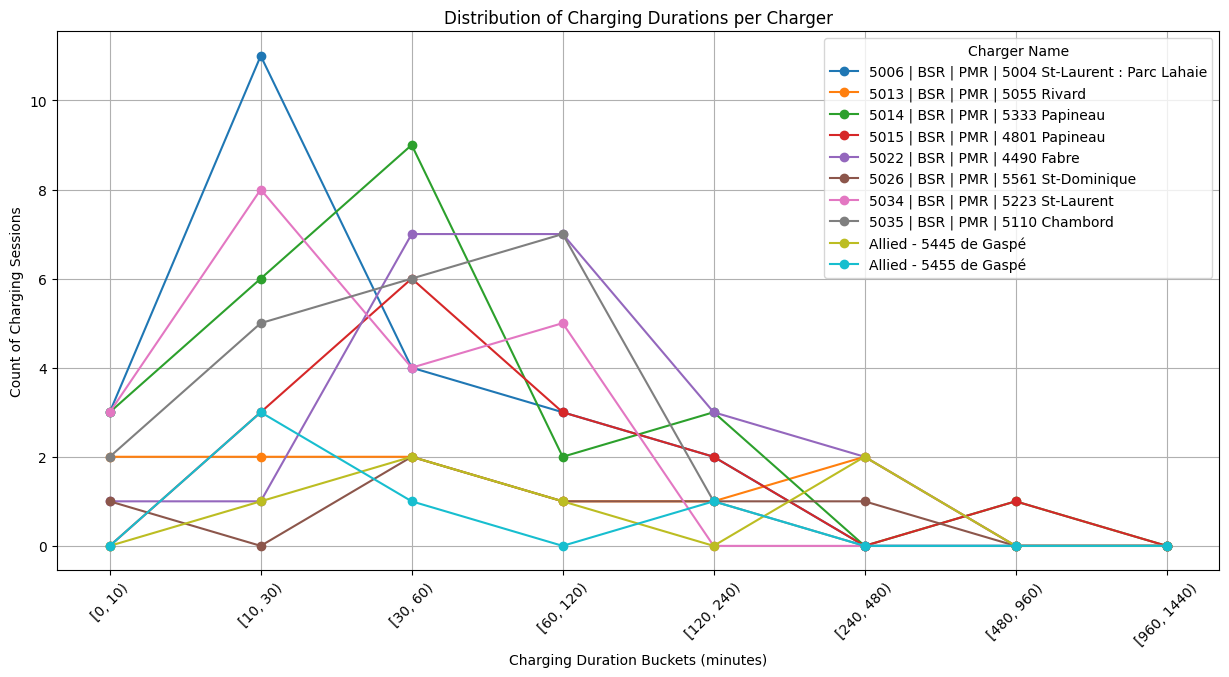

In [145]:
# Plot the distribution of charging durations for each charger
fig, ax = plt.subplots(figsize=(15, 7))

# Plot each charger separately
for charger in bucket_counts.index:
    ax.plot(bucket_counts.columns, bucket_counts.loc[charger], marker='o', label=charger)

plt.xlabel('Charging Duration Buckets (minutes)')
plt.ylabel('Count of Charging Sessions')
plt.title('Distribution of Charging Durations per Charger')
plt.legend(title='Charger Name')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

This is an image of what was produced previously. It looked nice a nice normal distribution around a mean. I don't trust the current result above. What do you think?.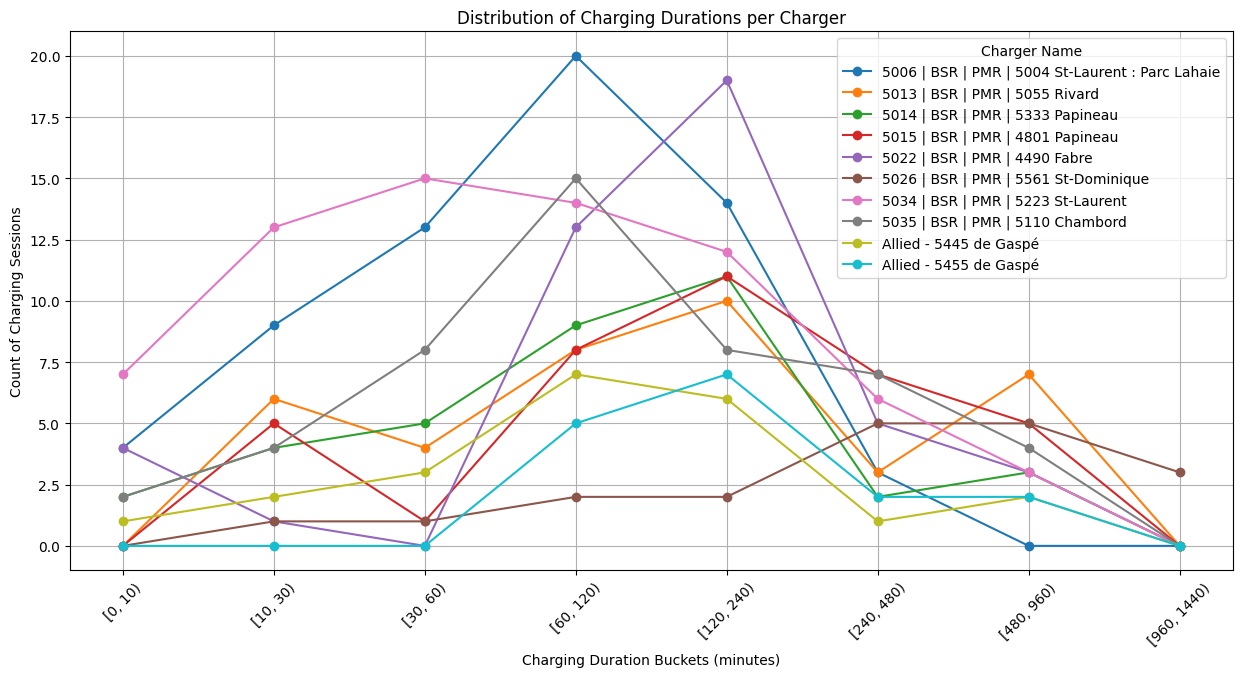